# Modeling and Simulation in Python

Chapter 18

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Data

We have data from Pacini and Bergman (1986), "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 23: 113-122..

In [2]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time');

The return value from `interpolate` is a function.

In [3]:
I = interpolate(data.insulin)

In [4]:
k1 = 0.03
k2 = 0.02
k3 = 1e-05
G0 = 290

290

To estimate basal levels, we'll use the concentrations at `t=0`.

In [5]:
Gb = data.glucose[0]
Ib = data.insulin[0]

11

In the initial conditions, `X(0)=0` and `G(0)=G0`, where `G0` is one of the parameters we'll choose.

In [6]:
init = State(G=G0, X=0)

,values
G,290
X,0


Here's the system object with all parameters and the interpolation object `I`.

In [7]:
system = System(init=init, 
                k1=k1, k2=k2, k3=k3,
                I=I, Gb=Gb, Ib=Ib,
                t0=0, t_end=182, dt=2)

,values
init,G 290 X 0 dtype: int64
k1,0.03
k2,0.02
k3,1e-05
I,<scipy.interpolate.interpolate.interp1d object...
Gb,92
Ib,11
t0,0
t_end,182
dt,2


In [8]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    unpack(system)
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [53]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    ts = linrange(t0, t_end-dt, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

And here's how we run it.  

In [54]:
%time results = run_simulation(system, update_func);

CPU times: user 264 ms, sys: 12 ms, total: 276 ms
Wall time: 271 ms


In [11]:
results

,G,X
0,290.000000,0.000000
2,278.120000,0.000000
4,266.952800,0.000300
6,256.295460,0.002668
8,245.070140,0.004041
10,233.905138,0.004680
12,223.201651,0.005252
14,212.984844,0.005722
16,203.288207,0.006093
18,194.133461,0.006330


### Numerical solution

We can do the same thing using `odeint`.  Instead of an update function, we provide a slope function that evaluates the right-hand side of the differential equations.  We don't have to do the update part; `odeint` does it for us.

In [12]:
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivatives of G and X
    """
    G, X = state
    unpack(system)
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

We can test the slope function with the initial conditions.

In [13]:
slope_func(init, 0, system)

(-5.9399999999999995, 0.0)

The `System` object we use with `run_odeint` is almost the same as the one we used with `run_simulation`, but instead of providing `t0`, `t_end`, and `dt`, we provide an array of times where we want to evaluate the solution.  In this case, we use `data.index`, so the results are evaluated at the same times as the measurements.

In [14]:
system2 = System(init=init, 
                 k1=k1, k2=k2, k3=k3,
                 I=I, Gb=Gb, Ib=Ib,
                 ts=data.index)

,values
init,G 290 X 0 dtype: int64
k1,0.03
k2,0.02
k3,1e-05
I,<scipy.interpolate.interpolate.interp1d object...
Gb,92
Ib,11
ts,"Int64Index([ 0, 2, 4, 6, 8, 10, 12,..."


`run_odeint` is a wrapper for `scipy.integrate.odeint`

In [15]:
%psource run_odeint

def run_odeint(system, slope_func, **options):
    """Runs a simulation of the system.

    `system` should contain system parameters and `ts`, which
    is an array or Series that specifies the time when the
    solution will be computed.

    system: System object
    slope_func: function that computes slopes

    returns: TimeFrame
    """
    # makes sure `system` contains `ts`
    if not hasattr(system, 'ts'):
        msg = """It looks like `system` does not contain `ts`
                 as a system variable.  `ts` should be an array
                 or Series that specifies the times when the
                 solution will be computed:"""
        raise ValueError(msg)

    # makes sure `system` contains `ts`
    if not hasattr(system, 'init'):
        msg = """It looks like `system` does not contain `init`
                 as a system variable.  `init` should be a State
                 object that specifies the initial condition:"""
        raise ValueError(msg)

    # make the 

Here's how we run it.

In [16]:
%time results2 = run_odeint(system2, slope_func);

CPU times: user 220 ms, sys: 0 ns, total: 220 ms
Wall time: 212 ms


And here are the results.

In [17]:
results2

,G,X
time,,
0,290.000000,0.000000
2,278.441946,0.000148
4,267.246339,0.001463
6,255.791154,0.003294
8,244.385049,0.004280
10,233.385689,0.004877
12,222.875391,0.005391
14,212.883104,0.005807
16,203.432604,0.006108


Plotting the results from `run_simulation` and `run_odeint`, we can see that they are not very different.

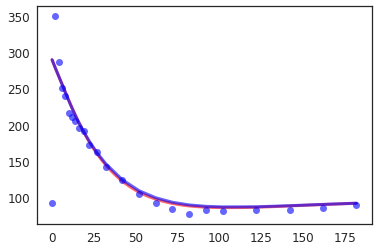

In [18]:
plot(results.G, 'r-')
plot(results2.G, 'b-')
plot(data.glucose, 'bo')

The differences in `G` are usually less than 1% and always less than 2%.

In [19]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100
percent_diff.dropna()

0      0.000000
2     -0.115624
4     -0.109838
6      0.197156
8      0.280333
10     0.222571
12     0.146387
14     0.047791
16    -0.070980
22    -0.506705
32    -1.135176
42    -1.553518
52    -1.824149
62    -1.877001
72    -1.764022
82    -1.574539
92    -1.346686
102   -1.093100
122   -0.676648
142   -0.393212
162   -0.187146
182   -0.077205
Name: G, dtype: float64

**Exercise:** What happens to these errors if you run the simulation with a smaller value of `dt`?

### Optimization

Now let's find the parameters that yield the best fit for the data.

In [20]:
k1 = 0.03
k2 = 0.02
k3 = 1e-05
G0 = 290

290

Again, we'll get basal levels from the initial values.

In [21]:
Gb = data.glucose[0]
Ib = data.insulin[0]

11

And the slope function is the same.

In [22]:
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivatives of G and X
    """
    G, X = state
    unpack(system)
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

`make_system` takes the parameters and `DataFrame` and returns a `System` object.

In [33]:
def make_system(params, data):
    """Makes a System object with the given parameters.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    G0, k1, k2, k3 = params
    init = State(G=G0, X=0)
    system = System(init=init, 
                    k1=k1, k2=k2, k3=k3,
                    Gb=Gb, Ib=Ib, 
                    I=interpolate(data.insulin),
                    ts=data.index)
    return system

`error_func` takes the parameters and actual data, makes a `System` object and runs it, then compares the results of the simulation to the data.  It returns an array of errors.

In [34]:
def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results = run_odeint(system, slope_func)
    
    # compute the difference between the model
    # results and actual data
    errors = results.G - data.glucose
    return errors

When we call `error_func`, we provide a sequence of parameters as a single object.

In [35]:
params = G0, k1, k2, k3
params

(290, 0.0267309385434166, 0.01335158143968368, 1.3226829295046203e-05)

Here's how that works:

In [36]:
error_func(params, data)

(290, 0.0267309385434166, 0.01335158143968368, 1.3226829295046203e-05)


time
0      198.000000
2      -70.344051
4      -17.566735
6        7.507060
8        7.290530
10      20.278027
12      14.602055
14      10.324373
16       9.499804
19      -0.287215
22       7.096361
27      -2.490364
32       2.697770
42      -4.066834
52      -2.090790
62      -0.203703
72       0.734789
82       3.568637
92      -3.589955
102     -3.380256
122     -3.831264
142     -1.397434
162     -1.362193
182     -3.254534
dtype: float64

`fit_leastsq` is a wrapper for `scipy.optimize.leastsq`

In [37]:
%psource fit_leastsq

def fit_leastsq(error_func, params, data, **options):
    """Find the parameters that yield the best fit for the data.

    `params` can be a sequence, array, or Series

    error_func: function that computes a sequence of errors
    params: initial guess for the best parameters
    data: the data to be fit; will be passed to min_fun
    options: any other arguments are passed to leastsq
    """
    # to pass `data` to `leastsq`, we have to put it in a tuple
    args = (data,)

    # override `full_output` so we get a message if something goes wrong
    options['full_output'] = True

    # run leastsq
    best_params, _, _, mesg, ier = leastsq(error_func, x0=params,
                                           args=args, **options)

    #TODO: check why logging.info is not visible

    # check for errors
    if ier in [1, 2, 3, 4]:
        print("""modsim.py: scipy.optimize.leastsq ran successfully
                 and returned the following message:\n""" + mesg)
    else:
        loggin

Here's how we call it.

In [38]:
best_params = fit_leastsq(error_func, params, data)

[2.90000000e+02 2.67309385e-02 1.33515814e-02 1.32268293e-05]
[2.90000000e+02 2.67309385e-02 1.33515814e-02 1.32268293e-05]
[2.90000000e+02 2.67309385e-02 1.33515814e-02 1.32268293e-05]
[2.90000004e+02 2.67309385e-02 1.33515814e-02 1.32268293e-05]
[2.90000000e+02 2.67309389e-02 1.33515814e-02 1.32268293e-05]
[2.90000000e+02 2.67309385e-02 1.33515816e-02 1.32268293e-05]
[2.90000000e+02 2.67309385e-02 1.33515814e-02 1.32268295e-05]
[2.89972550e+02 2.67118101e-02 1.33648983e-02 1.32320074e-05]
[2.89972555e+02 2.67118101e-02 1.33648983e-02 1.32320074e-05]
[2.89972550e+02 2.67118105e-02 1.33648983e-02 1.32320074e-05]
[2.89972550e+02 2.67118101e-02 1.33648985e-02 1.32320074e-05]
[2.89972550e+02 2.67118101e-02 1.33648983e-02 1.32320076e-05]
[2.89813010e+02 2.67194223e-02 1.33626529e-02 1.32296584e-05]
[2.89813014e+02 2.67194223e-02 1.33626529e-02 1.32296584e-05]
[2.89813010e+02 2.67194227e-02 1.33626529e-02 1.32296584e-05]
[2.89813010e+02 2.67194223e-02 1.33626531e-02 1.32296584e-05]
[2.89813

array([2.88394998e+02, 2.67574271e-02, 1.34191158e-02, 1.32305408e-05])

Now that we have `best_params`, we can use it to make a `System` object and run it.

In [39]:
system = make_system(best_params, data)
results = run_odeint(system, slope_func)

,G,X
time,,
0,288.394998,0.000000
2,278.124830,0.000197
4,267.974878,0.001947
6,257.124572,0.004412
8,245.985079,0.005782
10,235.048204,0.006647
12,224.445687,0.007410
14,214.239021,0.008049
16,204.482755,0.008541


Here are the results, along with the data.  The first few points of the model don't fit the data, but we don't expect them to.

Saving figure to file figs/chap08-fig04.pdf


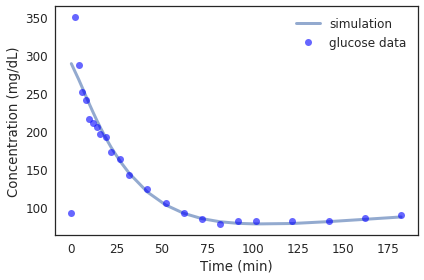

In [40]:
plot(results.G, label='simulation')
plot(data.glucose, 'bo', label='glucose data')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

savefig('figs/chap08-fig04.pdf')

### Interpreting parameters

Based on the parameters of the model, we can estimate glucose effectiveness and insulin sensitivity.

In [43]:
def indices(params):
    """Compute glucose effectiveness and insulin sensitivity.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: State object containing S_G and S_I
    """
    G0, k1, k2, k3 = params
    return State(S_G=k1, S_I=k3/k2)

Here are the results.

In [44]:
indices(best_params)

,values
S_G,0.026757
S_I,0.000986


## Exercises

**Exercise:** Since we don't expect the first few points to agree, it's probably better not to make them part of the optimization process.  We can ignore them by leaving them out of the `Series` returned by `error_func`.  Modify the last line of `error_func` to return `errors.loc[8:]`, which includes only the elements of the `Series` from `t=8` and up.

Does that improve the quality of the fit?  Does it change the best parameters by much?

Note: You can read more about this use of `loc` [in the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-integer).

**Exercise:** How sensitive are the results to the starting guess for the parameters.  If you try different values for the starting guess, do we get the same values for the best parameters?